#Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Installing Dependencies and Importing Modules

In [2]:
!pip install scikit-image

In [3]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

In [4]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from keras.utils import plot_model
from torchsummary import summary
from PIL import Image


import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [5]:
image_size = 64
stats = (0.5, 0.5, 0.5),(0.5, 0.5, 0.5)

In [6]:
def denorm(image_tensors):

    return image_tensors * stats[0][1] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images)
        break

#Load Dataset

In [8]:
datasheet = pd.read_csv('/content/drive/MyDrive/dlProjectData/DL-ClassProject-Data_ver1.csv')
datasheet.head()

File Name Face Shape              Type Color of Lip     Forehead  \
0   S1.jpeg    Diamond  Heavy lower lips         Pink  Fuzzi-Mount   
1  S50.jpeg  Rectangle  Heavy lower lips        Black        Broad   
2   S53.jpg     Oblong         Thin lips         Pink     Straight   
3  S54.jpeg    Diamond  Heavy upper lips         Pink        Broad   
4  S52.jpeg    Diamond  Heavy lower lips         Pink     Straight   

  Cheeks with Dimple        Shape    Eye Size             In Eye Eye Color  \
0                Yes  pointed ear     Big Eye  No visible defect     Brown   
1                 No   narrow ear  Medium Eye  No visible defect     Black   
2                 No   Broad lobe  Medium Eye  No visible defect      Gray   
3                 No  pointed ear  Medium Eye  No visible defect      Gray   
4                Yes   Broad lobe     Big Eye  No visible defect     Black   

   ...        Eyebrows Jaw Line Skin Color             Hair Color  \
0  ...  High Seperated    Sharp       Fair                  Black   
1  ...       Seperated     Flat       Dark                  Black   
2  ...       Seperated     Flat      White  Black and white mixed   
3  ...       Seperated    Sharp      White                 Golden   
4  ...  High Seperated    Sharp       Fair                  Black   

           Hair Style Beard Mustache Style      Nose  \
0      Long hair girl               Shaven  Straight   
1           Half Bald               Shaven    Raised   
2  Medium length male               Shaven   Lowered   
3      Long hair girl               Shaven  Straight   
4      Long hair girl               Shaven  Straight   

  Age (Rough estimate as appearing)  Gender  \
0                                32  Female   
1                                18    Male   
2                                50    Male   
3                                32  Female   
4                                31  Female   

  Identification mark if any (describe)  
0                                    No  
1                                    na  
2                                   Non  
3                                   NaN  
4                                    No  

[5 rows x 21 columns]

In [9]:
train_df = pd.DataFrame(datasheet)

In [10]:
train_df

File Name Face Shape               Type Color of Lip     Forehead  \
0      S1.jpeg    Diamond   Heavy lower lips         Pink  Fuzzi-Mount   
1     S50.jpeg  Rectangle   Heavy lower lips        Black        Broad   
2      S53.jpg     Oblong          Thin lips         Pink     Straight   
3     S54.jpeg    Diamond   Heavy upper lips         Pink        Broad   
4     S52.jpeg    Diamond   Heavy lower lips         Pink     Straight   
..         ...        ...                ...          ...          ...   
973  S986.jpeg       Oval   Heavy lower lips          Red       Narrow   
974   S987.jpg  Rectangle          Thin lips         Pink       Narrow   
975   S988.jpg    Diamond          Wide Lips         Pink       Narrow   
976  S989.jpeg       Oval  Heart shaped lips         Pink     Straight   
977   S990.jpg      Round          Thin lips         Pink     Straight   

    Cheeks with Dimple        Shape    Eye Size             In Eye Eye Color  \
0                  Yes  pointed ear     Big Eye  No visible defect     Brown   
1                   No   narrow ear  Medium Eye  No visible defect     Black   
2                   No   Broad lobe  Medium Eye  No visible defect      Gray   
3                   No  pointed ear  Medium Eye  No visible defect      Gray   
4                  Yes   Broad lobe     Big Eye  No visible defect     Black   
..                 ...          ...         ...                ...       ...   
973                 No   narrow ear  Medium Eye  No visible defect     Brown   
974                 No  pointed ear  Medium Eye  No visible defect     Hazel   
975                 No   Broad lobe  Medium Eye  No visible defect     Brown   
976                 No   narrow ear  Medium Eye  No visible defect      Gray   
977                 No   Broad lobe   Small Eye  No visible defect     Brown   

     ...        Eyebrows Jaw Line Skin Color             Hair Color  \
0    ...  High Seperated    Sharp       Fair                  Black   
1    ...       Seperated     Flat       Dark                  Black   
2    ...       Seperated     Flat      White  Black and white mixed   
3    ...       Seperated    Sharp      White                 Golden   
4    ...  High Seperated    Sharp       Fair                  Black   
..   ...             ...      ...        ...                    ...   
973  ...       Seperated    Round       Fair                  Black   
974  ...       Seperated    Sharp      White                  Black   
975  ...       Seperated    Sharp      Brown                  Brown   
976  ...          Joined    Sharp      White                  Black   
977  ...       Seperated    Sharp      White                  Black   

             Hair Style Beard Mustache Style      Nose  \
0        Long hair girl               Shaven  Straight   
1             Half Bald               Shaven    Raised   
2    Medium length male               Shaven   Lowered   
3        Long hair girl               Shaven  Straight   
4        Long hair girl               Shaven  Straight   
..                  ...                  ...       ...   
973  Medium length male      Stubble (short)  Straight   
974  Medium length male           Full beard      Wavy   
975      Long hair girl               Shaven   Concave   
976          Small hair               Shaven    Convex   
977      Long hair male             Van Dyke    Convex   

    Age (Rough estimate as appearing)  Gender  \
0                                  32  Female   
1                                  18    Male   
2                                  50    Male   
3                                  32  Female   
4                                  31  Female   
..                                ...     ...   
973                                28    Male   
974                                29    Male   
975                                26  Female   
976                                24    Male   
977                                30    Male   

    Identificati

In [11]:
len(train_df)

978

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded = le.fit_transform(train_df['Color of Lip'])
train_df['label_encoded'] = label_encoded
label_names = le.classes_
label_names

array(['Black', 'Pink', 'Red', 'Skin'], dtype=object)

In [13]:
train_df.head()

File Name Face Shape              Type Color of Lip     Forehead  \
0   S1.jpeg    Diamond  Heavy lower lips         Pink  Fuzzi-Mount   
1  S50.jpeg  Rectangle  Heavy lower lips        Black        Broad   
2   S53.jpg     Oblong         Thin lips         Pink     Straight   
3  S54.jpeg    Diamond  Heavy upper lips         Pink        Broad   
4  S52.jpeg    Diamond  Heavy lower lips         Pink     Straight   

  Cheeks with Dimple        Shape    Eye Size             In Eye Eye Color  \
0                Yes  pointed ear     Big Eye  No visible defect     Brown   
1                 No   narrow ear  Medium Eye  No visible defect     Black   
2                 No   Broad lobe  Medium Eye  No visible defect      Gray   
3                 No  pointed ear  Medium Eye  No visible defect      Gray   
4                Yes   Broad lobe     Big Eye  No visible defect     Black   

   ... Jaw Line Skin Color             Hair Color          Hair Style  \
0  ...    Sharp       Fair                  Black      Long hair girl   
1  ...     Flat       Dark                  Black           Half Bald   
2  ...     Flat      White  Black and white mixed  Medium length male   
3  ...    Sharp      White                 Golden      Long hair girl   
4  ...    Sharp       Fair                  Black      Long hair girl   

  Beard Mustache Style      Nose Age (Rough estimate as appearing)  Gender  \
0               Shaven  Straight                                32  Female   
1               Shaven    Raised                                18    Male   
2               Shaven   Lowered                                50    Male   
3               Shaven  Straight                                32  Female   
4               Shaven  Straight                                31  Female   

  Identification mark if any (describe) label_encoded  
0                                    No             1  
1                                    na             0  
2                                   Non             1  
3                                   NaN             1  
4                                    No             1  

[5 rows x 22 columns]

In [14]:
img_transforms = transforms.Compose([transforms.Resize((600, 600)),
                                     transforms.CenterCrop(400),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

In [15]:
batch_size = 128
latent_size = 128

In [16]:
def get_default_device():

    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [17]:
def to_device(data, device):

    if isinstance(data, (list, tuple)):
        return [to_device(each, device) for each in data]
    else:
        return data.to(device, non_blocking = True)

In [18]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
        yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

#Creating Custom Dataset Class

In [20]:
class ImgDataset(Dataset):
  def __init__(self, data_frame, images_folder, transform = img_transforms):
    self.df = data_frame
    self.images_folder = images_folder
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()

    img_name = os.path.join(self.images_folder, self.df.iloc[index, 0])
    image = Image.open(img_name)
    label = self.df.iloc[index, -1]

    if self.transform:
        image = self.transform(image)

    return (image, label)

In [21]:
train_dataset = ImgDataset(train_df, "/content/drive/MyDrive/rawImgs2")

image, ColorOfLip = train_dataset[2]
print(ColorOfLip)

1


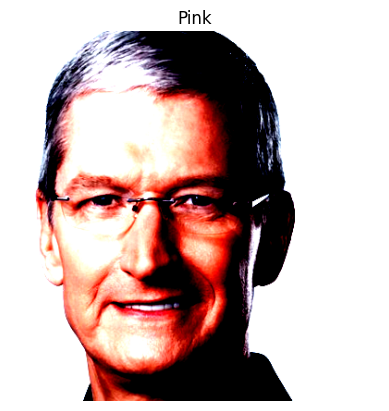

In [22]:
temp_img, temp_lab = train_dataset[2]
plt.imshow(temp_img.numpy().transpose((1, 2, 0)))
plt.title(label_names[temp_lab])
plt.axis('off')
plt.show()

In [23]:
FOLDER_DIR = '/content/drive/MyDrive/rawImgs/organizedImgs'

In [24]:
dataset = ImageFolder(FOLDER_DIR, transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(*stats)]))

#Loading Custom Dataset

In [25]:
dataloader = DataLoader(dataset, batch_size, shuffle=True, pin_memory = True, num_workers = 3)

In [26]:
dataloader = DeviceDataLoader(dataloader, device)

In [27]:
dataset

Dataset ImageFolder
    Number of datapoints: 977
    Root location: /content/drive/MyDrive/rawImgs/organizedImgs
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [28]:
DATA_DIR = '/content/drive/MyDrive/rawImgs/organizedImgs'
photos_in_folder = os.listdir(DATA_DIR)

In [29]:
cols = [0]
my_df = train_df[train_df.columns[cols]]
my_df.head()

File Name
0   S1.jpeg
1  S50.jpeg
2   S53.jpg
3  S54.jpeg
4  S52.jpeg

#Discriminator Network

In [30]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),

    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),

    nn.Flatten(),
    nn.Sigmoid()

)

In [31]:
discriminator = to_device(discriminator, device)
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

#Generator Network

In [32]:
latent_size = 128

In [33]:
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()

)

torch.Size([128, 3, 64, 64])


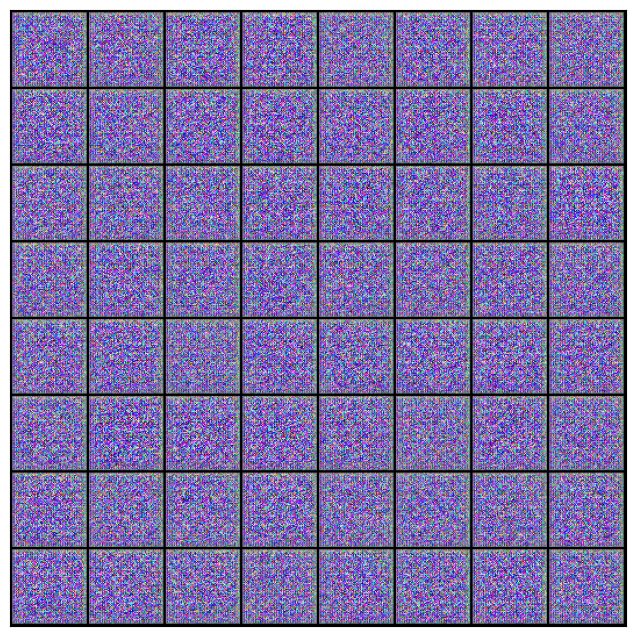

In [34]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)

print(fake_images.shape)
show_images(fake_images)

In [35]:
generator = to_device(generator, device)
summary(generator, (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

#Training Functions

In [36]:
def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

In [37]:
def train_generator(opt_g):

    opt_g.zero_grad()


    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device = device)
    loss = F.binary_cross_entropy(fake_preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [38]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [39]:
def save_samples(index, latent_tensors, show = True):

    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [40]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


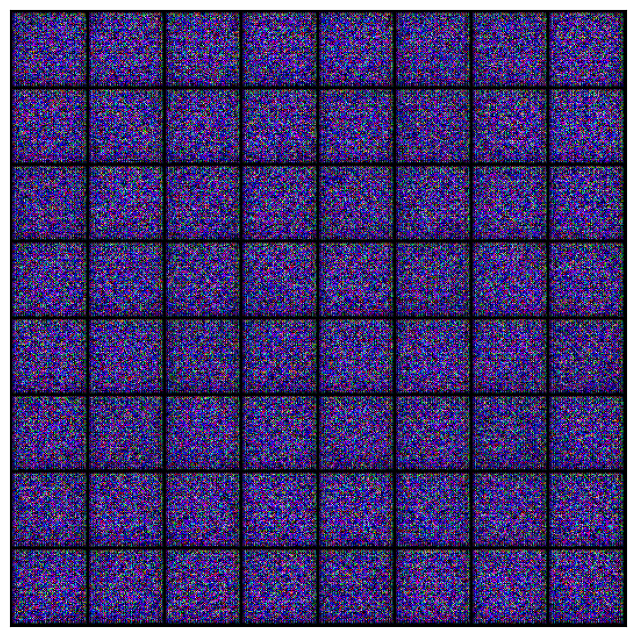

In [41]:
save_samples(0, fixed_latent)

In [42]:
def mainTraining(epochs, lr, start_idx = 1):

    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))

    for epoch in range(epochs):

        for real_images,_ in tqdm(dataloader):

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [43]:
lr = 0.0002
epochs = 100

In [44]:
history = mainTraining(epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 6.7803, loss_d: 0.3818, real_score: 0.8979, fake_score: 0.2093
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 11.7726, loss_d: 0.6570, real_score: 0.9410, fake_score: 0.4243
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 13.8230, loss_d: 0.1639, real_score: 0.8854, fake_score: 0.0001
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 5.5788, loss_d: 0.2187, real_score: 0.8735, fake_score: 0.0048
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 14.2716, loss_d: 0.3772, real_score: 0.7398, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.8160, loss_d: 0.2064, real_score: 0.9127, fake_score: 0.0929
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 9.2117, loss_d: 0.1299, real_score: 0.9003, fake_score: 0.0053
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 8.0821, loss_d: 0.8812, real_score: 0.8432, fake_score: 0.4513
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 6.0111, loss_d: 0.2034, real_score: 0.8745, fake_score: 0.0425
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.6900, loss_d: 0.2727, real_score: 0.8815, fake_score: 0.1219
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 5.3465, loss_d: 0.2065, real_score: 0.9001, fake_score: 0.0719
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 5.7858, loss_d: 0.1764, real_score: 0.9072, fake_score: 0.0630
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 5.3052, loss_d: 0.1564, real_score: 0.9160, fake_score: 0.0567
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 5.6466, loss_d: 0.0926, real_score: 0.9564, fake_score: 0.0447
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 5.8199, loss_d: 0.1160, real_score: 0.9517, fake_score: 0.0605
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 5.4811, loss_d: 0.0925, real_score: 0.9538, fake_score: 0.0376
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 5.9205, loss_d: 0.1415, real_score: 0.9195, fake_score: 0.0484
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 6.2664, loss_d: 0.0915, real_score: 0.9600, fake_score: 0.0456
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 16.5332, loss_d: 2.7864, real_score: 0.9809, fake_score: 0.8990
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.9095, loss_d: 0.1584, real_score: 0.9284, fake_score: 0.0567
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 5.4074, loss_d: 0.3886, real_score: 0.9401, fake_score: 0.2626
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 6.8478, loss_d: 0.8539, real_score: 0.8613, fake_score: 0.4789
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.0272, loss_d: 0.2748, real_score: 0.8782, fake_score: 0.1206
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 2.7775, loss_d: 0.4910, real_score: 0.7642, fake_score: 0.1388
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.1302, loss_d: 0.1600, real_score: 0.8842, fake_score: 0.0262
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.0750, loss_d: 0.5090, real_score: 0.6756, fake_score: 0.0532
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 4.5695, loss_d: 0.2890, real_score: 0.9540, fake_score: 0.2037
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 7.2960, loss_d: 0.4827, real_score: 0.9119, fake_score: 0.3065
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.5396, loss_d: 0.7417, real_score: 0.9508, fake_score: 0.4286
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.5139, loss_d: 0.3524, real_score: 0.8235, fake_score: 0.1110
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 2.4646, loss_d: 0.2613, real_score: 0.8857, fake_score: 0.1053
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.6952, loss_d: 0.4335, real_score: 0.8270, fake_score: 0.1918
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 5.9821, loss_d: 0.4298, real_score: 0.9379, fake_score: 0.2829
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 5.0799, loss_d: 0.4220, real_score: 0.9205, fake_score: 0.2609
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.0489, loss_d: 0.2619, real_score: 0.8883, fake_score: 0.1061
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.3180, loss_d: 0.7575, real_score: 0.5601, fake_score: 0.0156
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.3333, loss_d: 0.4621, real_score: 0.8558, fake_score: 0.2147
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 7.2812, loss_d: 0.7704, real_score: 0.9642, fake_score: 0.4672
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 7.6381, loss_d: 1.2336, real_score: 0.9716, fake_score: 0.6212
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.6960, loss_d: 0.4949, real_score: 0.7794, fake_score: 0.1376
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.7558, loss_d: 0.5456, real_score: 0.8994, fake_score: 0.3223
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.2039, loss_d: 0.2704, real_score: 0.8927, fake_score: 0.1188
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 1.9083, loss_d: 0.8749, real_score: 0.5390, fake_score: 0.0277
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.2556, loss_d: 0.6154, real_score: 0.6291, fake_score: 0.0386
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.9503, loss_d: 0.3051, real_score: 0.8240, fake_score: 0.0666
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 4.0971, loss_d: 0.3278, real_score: 0.8846, fake_score: 0.1637
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 3.9220, loss_d: 0.2939, real_score: 0.9178, fake_score: 0.1565
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.6793, loss_d: 0.6890, real_score: 0.6115, fake_score: 0.0381
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 5.5152, loss_d: 0.6810, real_score: 0.8457, fake_score: 0.3296
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 6.0180, loss_d: 0.6033, real_score: 0.9648, fake_score: 0.3679
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.9291, loss_d: 0.3816, real_score: 0.7698, fake_score: 0.0751
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.1558, loss_d: 0.4025, real_score: 0.8324, fake_score: 0.1733
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.2213, loss_d: 0.2405, real_score: 0.9467, fake_score: 0.1612
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.2972, loss_d: 0.3551, real_score: 0.7886, fake_score: 0.0667
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 4.3185, loss_d: 0.7050, real_score: 0.9471, fake_score: 0.4354
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.7232, loss_d: 0.6642, real_score: 0.9123, fake_score: 0.3817
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 3.5658, loss_d: 0.4495, real_score: 0.8066, fake_score: 0.1793
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.0630, loss_d: 0.4975, real_score: 0.7095, fake_score: 0.0778
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 5.6335, loss_d: 0.5730, real_score: 0.8924, fake_score: 0.3301
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.8587, loss_d: 0.4312, real_score: 0.8584, fake_score: 0.2206
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 3.9800, loss_d: 0.2609, real_score: 0.9024, fake_score: 0.1353
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.3387, loss_d: 0.1687, real_score: 0.9400, fake_score: 0.0947
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.8956, loss_d: 0.3570, real_score: 0.9617, fake_score: 0.2268
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 5.8169, loss_d: 0.9524, real_score: 0.9887, fake_score: 0.5369
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.6456, loss_d: 0.5963, real_score: 0.8577, fake_score: 0.3219
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.3369, loss_d: 0.3048, real_score: 0.8830, fake_score: 0.1512
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.3867, loss_d: 0.6259, real_score: 0.6554, fake_score: 0.1130
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.2874, loss_d: 0.4032, real_score: 0.7399, fake_score: 0.0556
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.6758, loss_d: 0.3237, real_score: 0.8785, fake_score: 0.1636
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 3.1572, loss_d: 0.2949, real_score: 0.8073, fake_score: 0.0503
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.5599, loss_d: 0.2223, real_score: 0.8835, fake_score: 0.0820
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 5.0368, loss_d: 0.1946, real_score: 0.9438, fake_score: 0.1192
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 6.4547, loss_d: 0.8871, real_score: 0.8998, fake_score: 0.4844
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.2426, loss_d: 1.0954, real_score: 0.4255, fake_score: 0.0175
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 2.9479, loss_d: 0.3748, real_score: 0.8333, fake_score: 0.1440
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.3132, loss_d: 0.5419, real_score: 0.6516, fake_score: 0.0234
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.4934, loss_d: 0.4022, real_score: 0.8654, fake_score: 0.1999
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 7.5137, loss_d: 1.3595, real_score: 0.9900, fake_score: 0.6788
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.0592, loss_d: 0.5684, real_score: 0.6534, fake_score: 0.0401
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.1632, loss_d: 0.3307, real_score: 0.8227, fake_score: 0.1075
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 2.8712, loss_d: 0.4693, real_score: 0.7669, fake_score: 0.1464
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.4423, loss_d: 0.2896, real_score: 0.9127, fake_score: 0.1684
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.4320, loss_d: 0.4888, real_score: 0.7356, fake_score: 0.1235
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 6.2304, loss_d: 1.1627, real_score: 0.9834, fake_score: 0.5921
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.4431, loss_d: 0.3433, real_score: 0.8865, fake_score: 0.1755
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.3562, loss_d: 0.2868, real_score: 0.9191, fake_score: 0.1611
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.4227, loss_d: 0.3807, real_score: 0.7933, fake_score: 0.1138
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 3.1374, loss_d: 0.3433, real_score: 0.8189, fake_score: 0.1156
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 2.6502, loss_d: 1.6884, real_score: 0.2733, fake_score: 0.0024
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.2031, loss_d: 0.4337, real_score: 0.8802, fake_score: 0.2291
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.5560, loss_d: 0.9713, real_score: 0.4763, fake_score: 0.0176
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.4752, loss_d: 0.3455, real_score: 0.8308, fake_score: 0.1263
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 3.6222, loss_d: 0.3043, real_score: 0.8520, fake_score: 0.1137
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 5.8821, loss_d: 0.5445, real_score: 0.9126, fake_score: 0.3266
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 5.3390, loss_d: 0.4737, real_score: 0.8765, fake_score: 0.2593
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.9533, loss_d: 0.2414, real_score: 0.8820, fake_score: 0.0969
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.0202, loss_d: 0.4352, real_score: 0.7109, fake_score: 0.0333
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 5.2139, loss_d: 0.4701, real_score: 0.9558, fake_score: 0.3054
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 6.5387, loss_d: 1.1795, real_score: 0.9807, fake_score: 0.6094
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.3198, loss_d: 0.4417, real_score: 0.9477, fake_score: 0.2862
Saving generated-images-0100.png


In [45]:
losses_g, losses_d, real_scores, fake_scores = history

In [46]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [47]:
from IPython.display import Image

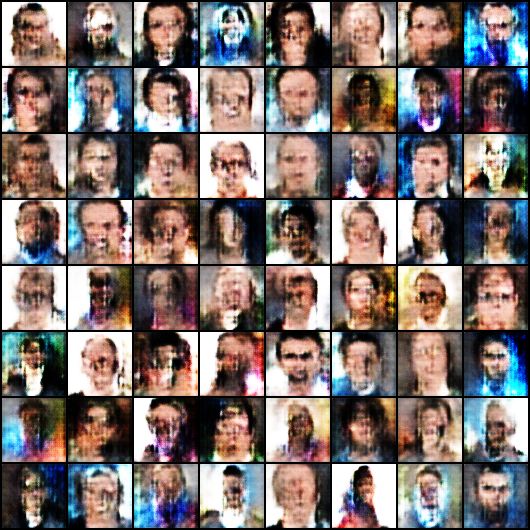

In [48]:
Image('/content/generated/generated-images-0100.png')

#Plotting Losses



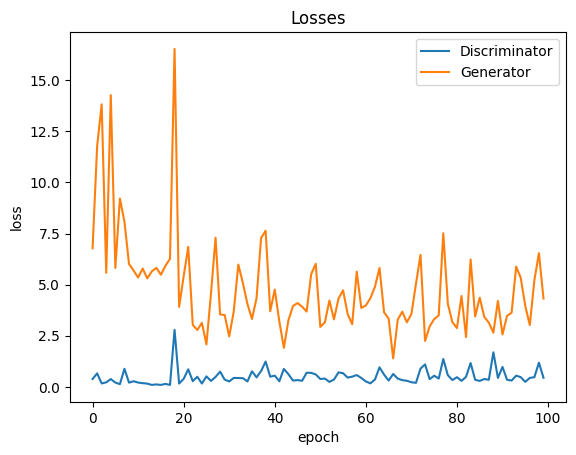

In [49]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

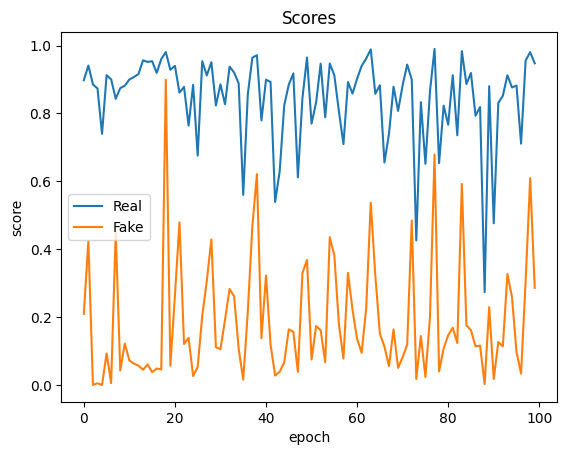

In [50]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');